`CE180384` - Nguyễn Vũ Huy

# `Week2 - Dataset`

### **1. Import Libraries**

In [4]:
import os
import cv2
import shutil
import random
import pandas as pd
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomRotation, RandomHorizontalFlip
from sklearn.utils import resample
from torch.utils.data import Dataset, DataLoader
from PIL import Image

c:\Users\VUHUY\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **2. Frame Extraction and Data Organization**

#### Define Function to Extract Frames

In [7]:
def extract_frames(video_path, output_folder):
    """
    Extract frames from a video and save them to the destination folder.
    Deletes the original video file after extraction.
    """
    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_name = os.path.join(output_folder, f"frame_{frame_count}.jpg")
        cv2.imwrite(frame_name, frame)
        frame_count += 1

    cap.release()
    os.remove(video_path)
    print(f"Extracted {frame_count} frames from {video_path}")

#### Define Function to Split and Organize Data

In [8]:
def split_data(src_folder, dest_folder, categories, train_ratio=0.8):
    """
    Split video data into training and testing sets, extract frames, and remove original video files.
    Saves organized data into `dest_folder`.
    """
    metadata = {'path': [], 'label': [], 'split': []}

    for category in categories:
        category_folder = os.path.join(src_folder, category)
        if not os.path.exists(category_folder):
            print(f"Folder {category_folder} does not exist.")
            continue

        videos = os.listdir(category_folder)
        random.shuffle(videos)
        split_idx = int(train_ratio * len(videos))
        train_videos, test_videos = videos[:split_idx], videos[split_idx:]

        for split, video_list in zip(['train', 'test'], [train_videos, test_videos]):
            split_category_folder = os.path.join(dest_folder, split, category)
            os.makedirs(split_category_folder, exist_ok=True)

            for video in video_list:
                video_path = os.path.join(category_folder, video)
                video_output_folder = os.path.join(split_category_folder, video.split('.')[0])
                extract_frames(video_path, video_output_folder)

                for frame in os.listdir(video_output_folder):
                    metadata['path'].append(os.path.join(video_output_folder, frame))
                    metadata['label'].append(category)
                    metadata['split'].append(split)

    return pd.DataFrame(metadata)

#### Define Function to Split and Organize Data

In [9]:
def split_data(src_folder, dest_folder, categories, train_ratio=0.8):
    """
    Split video data into training and testing sets, extract frames, and remove original video files.
    Saves organized data into `dest_folder`.
    """
    metadata = {'path': [], 'label': [], 'split': []}

    for category in categories:
        category_folder = os.path.join(src_folder, category)
        if not os.path.exists(category_folder):
            print(f"Folder {category_folder} does not exist.")
            continue

        videos = os.listdir(category_folder)
        random.shuffle(videos)
        split_idx = int(train_ratio * len(videos))
        train_videos, test_videos = videos[:split_idx], videos[split_idx:]

        for split, video_list in zip(['train', 'test'], [train_videos, test_videos]):
            split_category_folder = os.path.join(dest_folder, split, category)
            os.makedirs(split_category_folder, exist_ok=True)

            for video in video_list:
                video_path = os.path.join(category_folder, video)
                video_output_folder = os.path.join(split_category_folder, video.split('.')[0])
                extract_frames(video_path, video_output_folder)

                for frame in os.listdir(video_output_folder):
                    metadata['path'].append(os.path.join(video_output_folder, frame))
                    metadata['label'].append(category)
                    metadata['split'].append(split)

    return pd.DataFrame(metadata)

### **3. Apply Transformations**

#### Define Transformation Pipeline

In [10]:
def get_transforms():
    """
    Returns transformations for preprocessing and data augmentation.
    """
    return Compose([
        Resize((224, 224)),
        RandomRotation(15),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

transforms = get_transforms()

### **4. Check for Data Imbalance**

#### Define Function to Check Class Distribution

In [11]:
def check_imbalance(dataframe):
    """
    Check for class imbalance in the dataset.
    """
    class_counts = dataframe['label'].value_counts()
    print("Class Distribution:")
    print(class_counts)
    return class_counts

### **5. Balance Dataset**

#### Define Function to Balance Dataset

In [12]:
def balance_dataset(dataframe):
    """
    Balance the dataset by oversampling minority classes.
    """
    max_count = dataframe['label'].value_counts().max()
    balanced_df = pd.DataFrame()

    for label in dataframe['label'].unique():
        class_data = dataframe[dataframe['label'] == label]
        balanced_class_data = resample(
            class_data,
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        balanced_df = pd.concat([balanced_df, balanced_class_data])

    return balanced_df.sample(frac=1).reset_index(drop=True)

### **6. Create Dataset and DataLoader**

#### Define Custom Dataset

In [13]:
class VideoFrameDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        label = self.dataframe.iloc[idx]['label']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

#### Define Function to Create DataLoader

In [14]:
def create_dataloader(dataframe, batch_size=32, shuffle=True):
    """
    Create DataLoader for given dataframe.
    """
    dataset = VideoFrameDataset(dataframe, transform=transforms)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

### **7. Main Pipeline Dataset**

In [11]:
# Define source and destination folders
src_folder = 'data'  # Source folder containing videos
dest_folder = 'organized_data'  # Destination folder for organized data
categories = ['fake', 'real']

In [12]:
# Step 1: Split data and extract frames
metadata_df = split_data(src_folder, dest_folder, categories)

Extracted 591 frames from data\fake\08_28__outside_talking_pan_laughing__8BC35RFU.mp4
Extracted 403 frames from data\fake\07_21__exit_phone_room__K7KXUHMU.mp4
Extracted 686 frames from data\fake\06_20__kitchen_pan__6SUW7063.mp4
Extracted 982 frames from data\fake\02_15__walking_and_outside_surprised__I8G2LWD1.mp4
Extracted 382 frames from data\fake\04_01__exit_phone_room__0XUW13RW.mp4
Extracted 960 frames from data\fake\03_13__meeting_serious__T3MZOI8X.mp4
Extracted 292 frames from data\fake\01_12__outside_talking_pan_laughing__TNI7KUZ6.mp4
Extracted 315 frames from data\fake\06_11__walking_outside_cafe_disgusted__MX659QU8.mp4
Extracted 1058 frames from data\fake\02_12__podium_speech_happy__9D2ZHEKW.mp4
Extracted 477 frames from data\fake\07_03__walking_outside_cafe_disgusted__F0YYEA5W.mp4
Extracted 1279 frames from data\fake\02_06__talking_angry_couch__MKZTXQ2T.mp4
Extracted 840 frames from data\fake\04_01__kitchen_still__6I623VU9.mp4
Extracted 710 frames from data\fake\03_18__walking

In [13]:
# Step 2: Save metadata to CSV
metadata_df.to_csv('metadata.csv', index=False)
print("Metadata saved to metadata.csv")

Metadata saved to metadata.csv


In [14]:
# Step 3: Check for imbalance
print("Checking imbalance...")
check_imbalance(metadata_df)

Checking imbalance...
Class Distribution:
real    169223
fake    142272
Name: label, dtype: int64


real    169223
fake    142272
Name: label, dtype: int64

In [18]:
# Step 4: Balance dataset
print("Balancing dataset...")
balanced_df = balance_dataset(metadata_df)

Balancing dataset...


In [19]:
# Step 5: Save balanced dataset to CSV
balanced_df.to_csv('balanced_metadata.csv', index=False)
print("Balanced metadata saved to balanced_metadata.csv")

Balanced metadata saved to balanced_metadata.csv


In [1]:
import pandas as pd
balanced_df = pd.read_csv('balanced_metadata.csv')

In [2]:
# 1️⃣ Mã hóa nhãn trước khi tạo DataLoader
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
balanced_df['label'] = label_encoder.fit_transform(balanced_df['label'])

In [15]:
# Step 6: Create DataLoader
train_df = balanced_df[balanced_df['split'] == 'train']
test_df = balanced_df[balanced_df['split'] == 'test']

train_loader = create_dataloader(train_df)
test_loader = create_dataloader(test_df, shuffle=False)

print("DataLoader is ready for use in training.")

DataLoader is ready for use in training.


torch.Size([32, 3, 224, 224]) tensor([1, 0, 1, 0, 0], dtype=torch.int32)


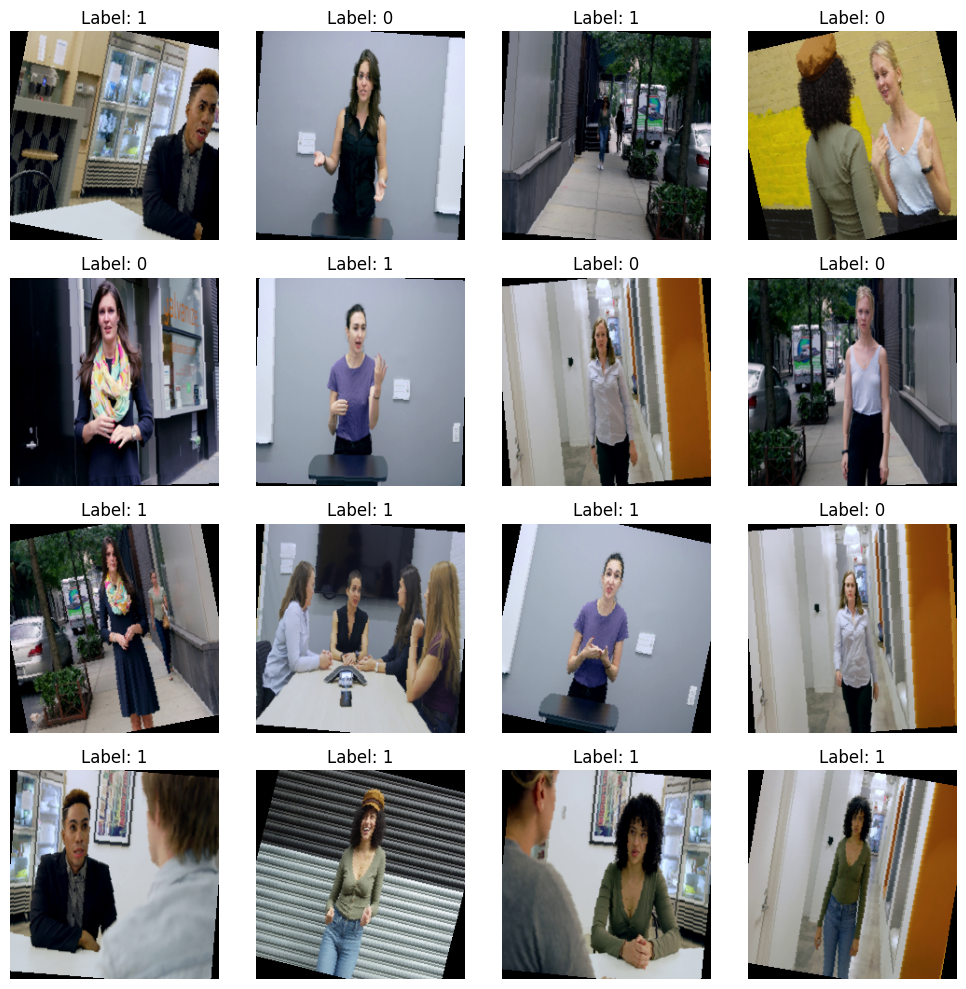

In [18]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch

# Lấy một batch hình ảnh và nhãn từ train_loader
for images, labels in train_loader:
    print(images.shape, labels[:5])  # Kiểm tra kích thước dữ liệu
    break

# Số lượng ảnh muốn hiển thị
num_images = min(16, images.shape[0])  # Lấy tối đa 16 ảnh

# Chuyển ảnh từ tensor về numpy để hiển thị
images_np = images[:num_images].permute(0, 2, 3, 1).numpy()

# Hiển thị hình ảnh với nhãn
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
axes = axes.flatten()  # Chuyển ma trận thành danh sách để dễ duyệt

for i in range(num_images):
    ax = axes[i]
    img = images_np[i]
    
    # Chuẩn hóa ảnh về khoảng [0,1] nếu cần
    img = (img - img.min()) / (img.max() - img.min())

    ax.imshow(img)
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis("off")  # Tắt trục tọa độ

plt.tight_layout()
plt.show()


# `Week3 - Building a Shallow Neural Network`